In [ ]:
# !pip install scikit-fmm

In [1]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import skfmm

In [2]:
print(jax.devices())

[CpuDevice(id=0)]


In [3]:
def fast_sweep_2d_numpy(grid, fixed_cells, obstacle, f, dh, iterations=5):
    # this is used for padding the outer boundaries of the domain,
    # so that the min() operations in the upwind scheme choose the inner point.
    large_val = 1e3
    ny, nx = grid.shape
    # 4 directions to sweep along - the range parameters for x and y.
    sweep_dirs = [
        (0, nx, 1, 0, ny, 1),  # Top-left to bottom-right
        (nx - 1, -1, -1, 0, ny, 1),  # Top-right to bottom-left
        (nx - 1, -1, -1, ny - 1, -1, -1),  # Bottom-right to top-left
        (0, nx, 1, ny - 1, -1, -1),  # Bottom-left to top-right
    ]

    # pad with a large value to properly handle boundary conditions in the upwind scheme.
    padded = np.pad(grid, pad_width=1, mode="constant", constant_values=large_val)

    for _ in range(iterations):
        for x_start, x_end, x_step, y_start, y_end, y_step in sweep_dirs:
            for iy in range(y_start, y_end, y_step):
                for ix in range(x_start, x_end, x_step):
                    # dont do anything for fixed cells (interface) or obstacles
                    if fixed_cells[iy, ix] or obstacle[iy, ix]:
                        continue
                    # calculate a,b from eqn 2.3 of Zhao et.al
                    py, px = iy + 1, ix + 1
                    # since it's a padded array and boundary+1 is a large value,
                    # it will choose the interior value at the end, acting like one sided difference.
                    a = np.min((padded[py, px - 1], padded[py, px + 1]))
                    b = np.min((padded[py - 1, px], padded[py + 1, px]))
                    # explicit unique solution to eq 2.3, given by eq 2.4
                    xbar = (
                        large_val  # xbar will be the distance to this cell from front
                    )
                    if np.abs(a - b) >= f * dh:
                        xbar = np.min((a, b)) + f * dh
                    else:
                        # can add small eps to sqrt later for stability
                        xbar = (a + b + np.sqrt(2 * (f * dh) ** 2 - (a - b) ** 2)) / 2
                    # update if new distance is smaller
                    padded[py, px] = np.min((padded[py, px], xbar))
    # return un-padded array
    return padded[1:-1, 1:-1]

In [4]:
@partial(jax.jit, static_argnames=["iterations"])
def fast_sweep_2d_jax(grid, fixed_cells, obstacle, f, dh, iterations=5):
    large_val = 1e3
    ny, nx = grid.shape
    sweep_dirs = [
        (0, nx, 1, 0, ny, 1),  # Top-left to bottom-right
        (nx - 1, -1, -1, 0, ny, 1),  # Top-right to bottom-left
        (nx - 1, -1, -1, ny - 1, -1, -1),  # Bottom-right to top-left
        (0, nx, 1, ny - 1, -1, -1),  # Bottom-left to top-right
    ]
    frozen = jnp.logical_or(fixed_cells, obstacle)
    padded = jnp.pad(grid, pad_width=1, mode="constant", constant_values=large_val)

    def run_sweep(sweep_dir, grid):
        x_start, x_end, x_step, y_start, y_end, y_step = sweep_dir

        def y_loop_body(iy, grid):
            def x_loop_body(ix, grid):
                piy, pix = iy + 1, ix + 1
                a = jnp.minimum(grid[piy, pix - 1], grid[piy, pix + 1])
                b = jnp.minimum(grid[piy - 1, pix], grid[piy + 1, pix])
                updated_val = jnp.where(
                    frozen[iy, ix],
                    grid[piy, pix],  # no change if frozen
                    jnp.minimum(  # min of curr and updated val
                        grid[piy, pix],
                        jnp.where(  # eqn 2.4
                            jnp.abs(a - b) >= f * dh,
                            jnp.minimum(a, b) + f * dh,
                            (a + b + jnp.sqrt(2 * (f * dh) ** 2 - (a - b) ** 2)) / 2,
                        ),
                    ),
                )
                return grid.at[piy, pix].set(updated_val)

            x_indices = jnp.arange(x_start, x_end, x_step)
            return jax.lax.fori_loop(
                0,
                len(x_indices),
                # ix is 0..len(x_indices) - we need to map it to actual range
                lambda ix, grid: x_loop_body(x_indices[ix], grid),
                grid,
            )

        y_indices = jnp.arange(y_start, y_end, y_step)
        return jax.lax.fori_loop(
            0,
            len(y_indices),
            lambda iy, grid: y_loop_body(y_indices[iy], grid),
            grid,
        )

    def iteration_body(_, cur_grid):
        # perform 4 sweeps (2 dimentions)
        grid_s1 = run_sweep(sweep_dirs[0], cur_grid)
        grid_s2 = run_sweep(sweep_dirs[1], grid_s1)
        grid_s3 = run_sweep(sweep_dirs[2], grid_s2)
        grid_s4 = run_sweep(sweep_dirs[3], grid_s3)
        return grid_s4

    final_grid = jax.lax.fori_loop(0, iterations, iteration_body, padded)
    return final_grid[1:-1, 1:-1]

# Execution example


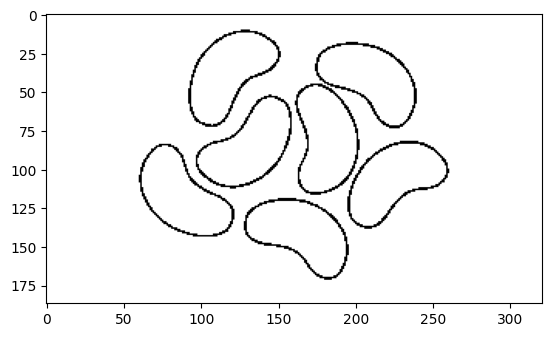

In [5]:
url = "https://raw.githubusercontent.com/RohanGautam/fast_sweep_jax/main/data/processed_beans.png"
response = requests.get(url)
img = np.array(Image.open(BytesIO(response.content)))
plt.imshow(img, cmap="grey")

In [6]:
print(img.shape)

(187, 321)


In [7]:
ny, nx = img.shape

# print(ny, nx)
# use arange not linspace, since grid spacing is not critical for an image (will be 1)
# in some applications, this can be important
X_np, Y_np = np.meshgrid(
    np.arange(0, nx),
    np.arange(0, ny),
)
dx = X_np[0, 1] - X_np[0, 0]
# dx=dy
dh = dx  # dh is grid spacing
interface_mask = img == 0
obstacle_mask = np.zeros_like(X_np)
# obstacle_mask[(X_np >= 50) & (X_np <= 55) & (Y_np >= 100) & (Y_np <= 125)] = 1
obstacle_mask[(X_np >= 50) & (X_np <= 55) & (Y_np >= 100)] = 1


dist_grid_np = np.ones_like(X_np) * 100.0  # set far away cells to be a large value
dist_grid_np[interface_mask] = 0.0


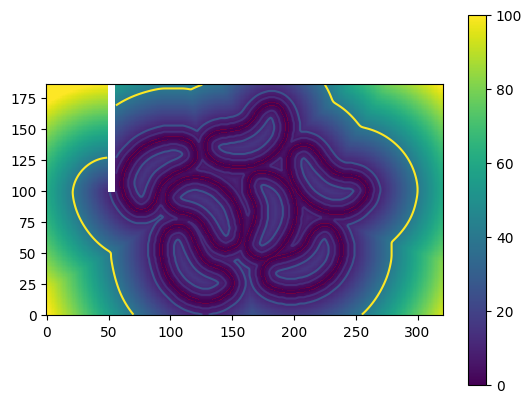

In [7]:
out = fast_sweep_2d_numpy(
    dist_grid_np,  # initial distance grid - 0 at interface, large val everywhere else
    interface_mask,  # 1 at interface, 0 elsewhere
    obstacle_mask,
    f=1,  # propagation speed
    dh=dh,  # grid spacing - is 1 for an image
    iterations=5,
)
out[obstacle_mask.astype(bool)] = np.nan

plt.pcolormesh(X_np, Y_np, out)
plt.colorbar()
plt.contour(X_np, Y_np, out, levels=[0], colors="red")
plt.contour(X_np, Y_np, out, levels=[0, 5, 10, 40])
plt.gca().set_aspect(1)

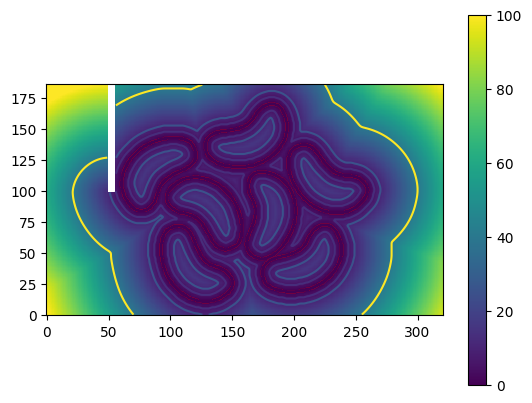

In [8]:
out = fast_sweep_2d_jax(
    jnp.array(dist_grid_np),
    jnp.array(interface_mask),
    jnp.array(obstacle_mask),
    f=1,
    dh=dh,
    iterations=5,
)
out = np.array(out)
out[obstacle_mask.astype(bool)] = np.nan

plt.pcolormesh(X_np, Y_np, out)
plt.colorbar()
plt.contour(X_np, Y_np, out, levels=[0], colors="red")
plt.contour(X_np, Y_np, out, levels=[0, 5, 10, 40])
plt.gca().set_aspect(1)

## fast marching method


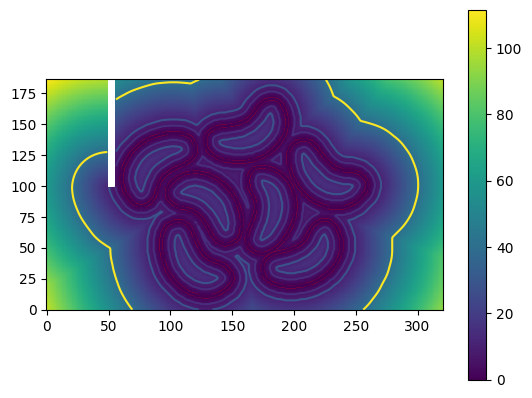

In [ ]:
phi = dist_grid_np
phi = np.ma.MaskedArray(phi, obstacle_mask)
speed = np.ones_like(phi)

travel_time = skfmm.travel_time(phi, speed, dx=[dh, dh])
travel_time[obstacle_mask.astype(bool)] = np.nan

plt.pcolormesh(X_np, Y_np, travel_time)
plt.colorbar()
plt.contour(X_np, Y_np, travel_time, levels=[0], colors="red")
plt.contour(X_np, Y_np, travel_time, levels=[0, 5, 10, 40])
plt.gca().set_aspect(1)

# Blog visuals

LLMs are great for these things :)


/var/folders/q6/dnbrfy_s2px965yzdl8jp8800000gp/T/ipykernel_76048/4033297274.py:4: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X_np, Y_np, interface_mask, levels=[0.5], colors="blue", linewidths=2, label="Initial Front")
/var/folders/q6/dnbrfy_s2px965yzdl8jp8800000gp/T/ipykernel_76048/4033297274.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(X_np, Y_np, obstacle_mask, levels=[0.5, 1], colors="red", alpha=0.5, label="Obstacle")


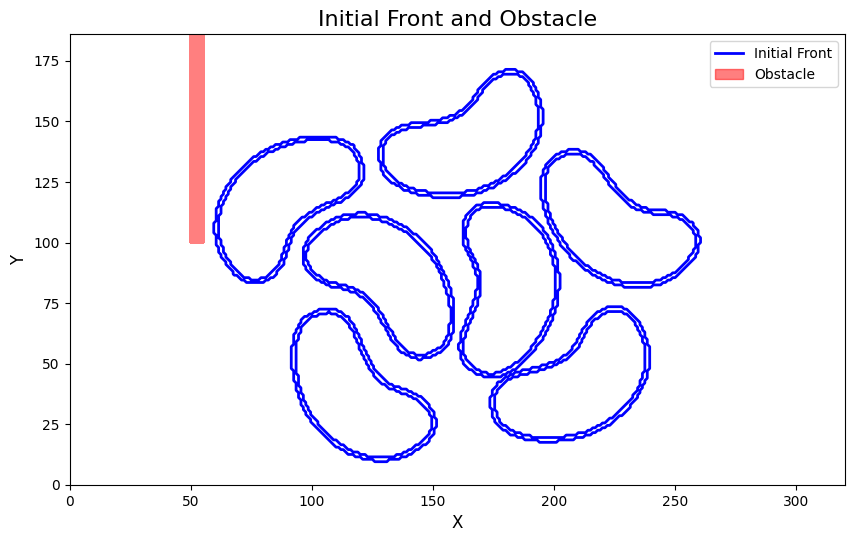

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the initial front (interface)
ax.contour(
    X_np,
    Y_np,
    interface_mask,
    levels=[0.5],
    colors="blue",
    linewidths=2,
    label="Initial Front",
)

# Plot the obstacle
ax.contourf(
    X_np,
    Y_np,
    obstacle_mask,
    levels=[0.5, 1],
    colors="red",
    alpha=0.5,
    label="Obstacle",
)

# Add labels and title
ax.set_title("Initial Front and Obstacle", fontsize=16)
ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)

# Add legend
front_patch = plt.Line2D([0], [0], color="blue", lw=2, label="Initial Front")
obstacle_patch = plt.Rectangle((0, 0), 1, 1, color="red", alpha=0.5, label="Obstacle")
ax.legend(handles=[front_patch, obstacle_patch], loc="upper right", fontsize=10)

# Set aspect ratio
ax.set_aspect(1)

plt.show()

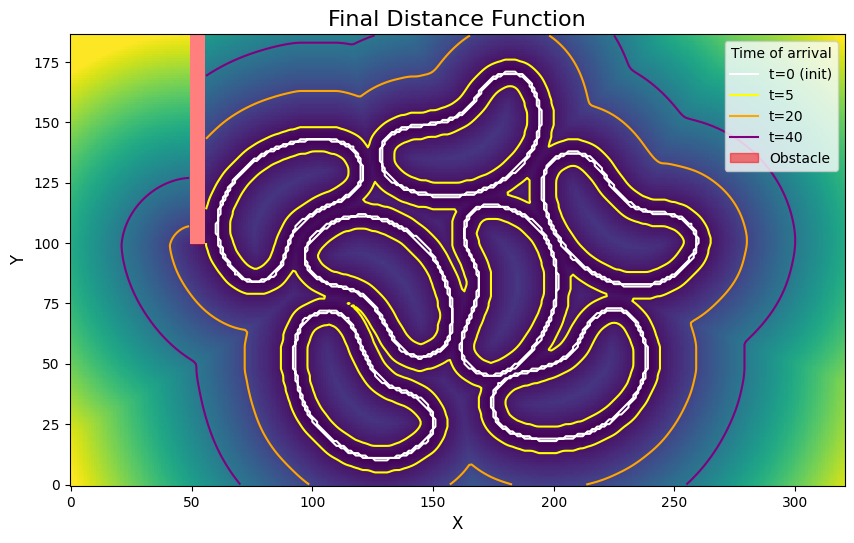

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the final SDF
sdf_plot = ax.pcolormesh(X_np, Y_np, out, cmap="viridis", shading="auto")

# Define contour levels and their corresponding colors
contour_levels = [0, 5, 20, 40]
contour_colors = ["white", "yellow", "orange", "purple"]

# Plot each contour level with a different color
contour_handles = []
for level, color in zip(contour_levels, contour_colors):
    contour = ax.contour(X_np, Y_np, out, levels=[level], colors=color, linewidths=1.5)
    contour_handles.append(
        plt.Line2D(
            [0],
            [0],
            color=color,
            lw=1.5,
            label=f"t={level}" if level != 0 else f"t={level} (init)",
        )
    )

# Plot the obstacle
ax.contourf(X_np, Y_np, obstacle_mask, levels=[0.5, 1], colors="red", alpha=0.5)

# Add the obstacle to the legend
obstacle_patch = plt.Rectangle((0, 0), 1, 1, color="red", alpha=0.5, label="Obstacle")
contour_handles.append(obstacle_patch)

# Add labels and title
ax.set_title("Final Distance Function", fontsize=16)
ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)

# Add a legend for the contour levels and obstacle
ax.legend(
    handles=contour_handles, loc="upper right", fontsize=10, title="Time of arrival"
)

# Set aspect ratio
ax.set_aspect(1)

plt.show()

In [26]:
def fast_sweep_2d_numpy_extra_info(grid, fixed_cells, obstacle, f, dh, iterations=5):
    large_val = 1e3
    ny, nx = grid.shape
    sweep_dirs = [
        (0, nx, 1, 0, ny, 1),
        (nx - 1, -1, -1, 0, ny, 1),
        (nx - 1, -1, -1, ny - 1, -1, -1),
        (0, nx, 1, ny - 1, -1, -1),
    ]

    padded = np.pad(grid, pad_width=1, mode="constant", constant_values=large_val)
    extra_out = []
    k = 0
    for _ in range(iterations):
        for x_start, x_end, x_step, y_start, y_end, y_step in sweep_dirs:
            for iy in range(y_start, y_end, y_step):
                for ix in range(x_start, x_end, x_step):
                    # dont do anything for fixed cells (interface) or obstacles
                    if fixed_cells[iy, ix] or obstacle[iy, ix]:
                        continue
                    # calculate a,b from eqn 2.3 of Zhao et.al
                    py, px = iy + 1, ix + 1
                    # since it's a padded array and boundary+1 is a large value,
                    # it will choose the interior value at the end, acting like one sided difference.
                    a = np.min((padded[py, px - 1], padded[py, px + 1]))
                    b = np.min((padded[py - 1, px], padded[py + 1, px]))
                    # explicit unique solution to eq 2.3, given by eq 2.4
                    xbar = (
                        large_val  # xbar will be the distance to this cell from front
                    )
                    if np.abs(a - b) >= f * dh:
                        xbar = np.min((a, b)) + f * dh
                    else:
                        # can add small eps to sqrt later for stability
                        xbar = (a + b + np.sqrt(2 * (f * dh) ** 2 - (a - b) ** 2)) / 2
                    # update if new distance is smaller
                    padded[py, px] = np.min((padded[py, px], xbar))
                    if k % 200 == 0:
                        extra_out.append(padded[1:-1, 1:-1].copy())
                    k += 1
    # return un-padded array
    return padded[1:-1, 1:-1], np.array(extra_out)


out, extra = fast_sweep_2d_numpy_extra_info(
    dist_grid_np,
    interface_mask,
    obstacle_mask,
    f=1,
    dh=dh,
    iterations=1,
)

In [27]:
extra.shape

(1147, 187, 321)

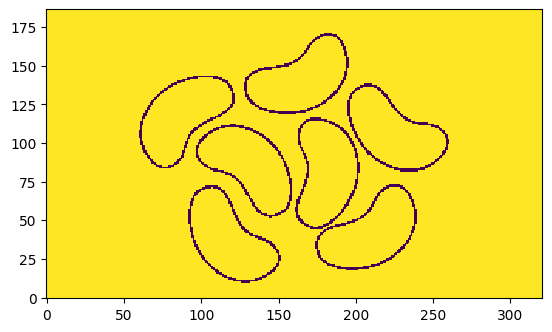

In [28]:
plt.pcolormesh(X_np, Y_np, extra[0, :, :], cmap="viridis", shading="auto")
plt.gca().set_aspect(1)

/var/folders/q6/dnbrfy_s2px965yzdl8jp8800000gp/T/ipykernel_80961/2172071619.py:27: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return (mesh, *obstacle_contour.collections)
/var/folders/q6/dnbrfy_s2px965yzdl8jp8800000gp/T/ipykernel_80961/2172071619.py:27: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return (mesh, *obstacle_contour.collections)


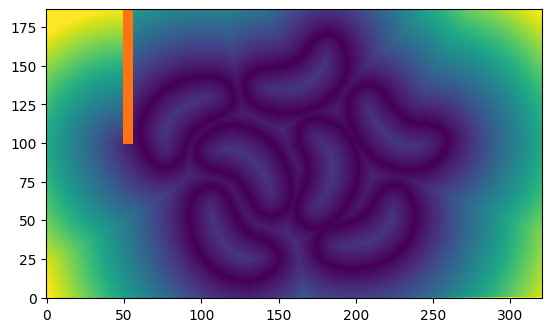

In [36]:
import matplotlib.animation as animation


extra_subset = extra[::10, :, :]
# Add the last frame 100 times to the extra_subset
extra_subset = np.concatenate(
    [extra_subset, np.repeat(extra[-1:, :, :], 100, axis=0)], axis=0
)
# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Initialize the pcolormesh plot
mesh = ax.pcolormesh(X_np, Y_np, extra_subset[0, :, :], cmap="viridis", shading="auto")
ax.set_aspect(1)

# plt.colorbar(mesh, ax=ax)

# Plot the obstacle mask (static, does not change with frames)
obstacle_contour = ax.contourf(
    X_np, Y_np, obstacle_mask, levels=[0.5, 1], colors="red", alpha=0.5
)


# Update function for the animation
def update(frame):
    mesh.set_array(extra_subset[frame, :, :].ravel())
    return (mesh, *obstacle_contour.collections)


gif_duration = 4  # seconds
desired_fps = extra_subset.shape[0] // gif_duration
interval_ms = int(1000 / desired_fps)  # Calculate interval in milliseconds

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=extra_subset.shape[0], interval=interval_ms, blit=True
)

# Save the animation as a GIF
ani.save("./data/fsm.gif", writer="pillow")

In [32]:
interval_ms

3

In [12]:
l = len(dist_grid_np.flatten())
l * (l // 500)

7203240

# Benchmarks


In [10]:
np_input = [
    dist_grid_np,
    interface_mask,
    obstacle_mask,
    1,
    dh,
    5,
]

jax_input = [
    jnp.array(dist_grid_np),
    jnp.array(interface_mask),
    jnp.array(obstacle_mask),
    1,
    dh,
    5,
]


In [45]:
%timeit fast_sweep_2d_numpy(*np_input)

8.29 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit fast_sweep_2d_jax(*jax_input).block_until_ready()

352 ms ± 8.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%timeit skfmm.travel_time(phi, speed, dx=[dh, dh])

10.5 ms ± 73.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


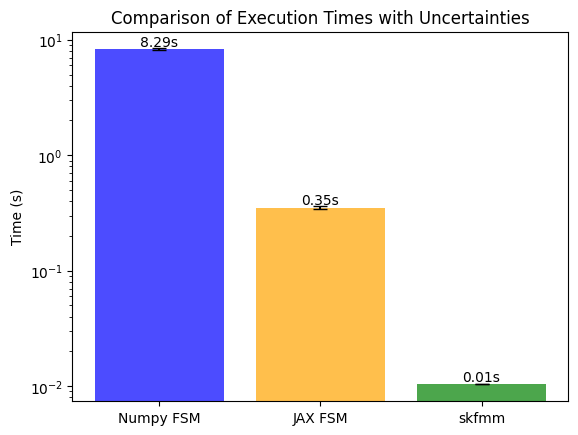

In [ ]:
means = [8.29, 352 * 1e-3, 10.4 * 1e-3]
stds = [114 * 1e-3, 8.84 * 1e-3, 57.7 * 1e-6]

labels = ["Numpy FSM", "JAX FSM", "skfmm"]
x = np.arange(len(labels))

fig, ax = plt.subplots()
bars = ax.bar(
    x, means, yerr=stds, capsize=5, color=["blue", "orange", "green"], alpha=0.7
)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Time (s)")
ax.set_yscale("log")
ax.set_title("Comparison of Execution Times with Uncertainties")

# Add mean times on the bars
for bar, mean in zip(bars, means):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{mean:.2f}s",
        ha="center",
        va="bottom",
    )

plt.show()